Machine 4 failure during Job 4 - Repair time: 271 - Adjusted processing time: 287
Machine 4 failure during Job 5 - Repair time: 449 - Adjusted processing time: 500
Machine 1 failure during Job 7 - Repair time: 61 - Adjusted processing time: 86
Status: Optimal
Total Tardiness in the System: 5408.0
Job 0 on Machine 0 starts at 0.0 and finishes at 74.0
Job 0 on Machine 1 starts at 74.0 and finishes at 95.0
Job 0 on Machine 2 starts at 95.0 and finishes at 153.0
Job 0 on Machine 3 starts at 153.0 and finishes at 236.0
Job 0 on Machine 4 starts at 236.0 and finishes at 267.0
Job 0 on Machine 5 starts at 267.0 and finishes at 328.0
Job 0 on Machine 6 starts at 328.0 and finishes at 422.0
Job 0 on Machine 7 starts at 422.0 and finishes at 488.0
Job 0 on Machine 8 starts at 488.0 and finishes at 525.0
Job 0 on Machine 9 starts at 525.0 and finishes at 624.0
Tardiness for Job 0: 0.0
Job 1 on Machine 0 starts at 74.0 and finishes at 102.0
Job 1 on Machine 1 starts at 102.0 and finishes at 129.0


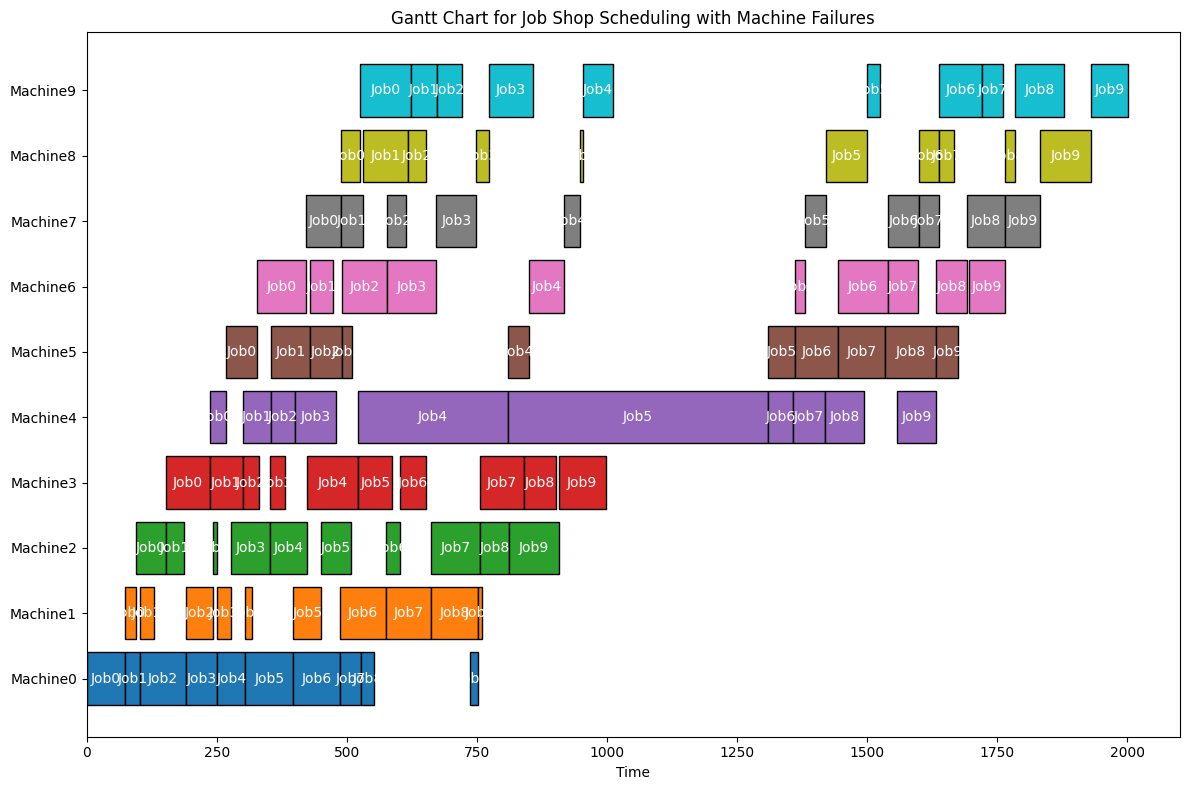

Start and Finish Times Matrix (including repair time):


,Job 0,Job 1,Job 2,Job 3,Job 4,Job 5,Job 6,Job 7,Job 8,Job 9
Machine 0,0.00 - 74.00,74.00 - 102.00,102.00 - 191.00,191.00 - 251.00,251.00 - 305.00,305.00 - 397.00,397.00 - 487.00,487.00 - 527.00,527.00 - 552.00,737.00 - 752.00
Machine 1,74.00 - 95.00,102.00 - 129.00,191.00 - 243.00,251.00 - 277.00,305.00 - 317.00,397.00 - 451.00,487.00 - 575.00,575.00 - 661.00,661.00 - 752.00,752.00 - 760.00
Machine 2,95.00 - 153.00,153.00 - 187.00,243.00 - 250.00,277.00 - 353.00,353.00 - 423.00,451.00 - 508.00,575.00 - 602.00,661.00 - 756.00,756.00 - 812.00,812.00 - 907.00
Machine 3,153.00 - 236.00,236.00 - 300.00,300.00 - 332.00,353.00 - 382.00,423.00 - 522.00,522.00 - 587.00,602.00 - 652.00,756.00 - 840.00,840.00 - 902.00,907.00 - 997.00
Machine 4,236.00 - 267.00,300.00 - 354.00,354.00 - 400.00,400.00 - 479.00,522.00 - 809.00,809.00 - 1309.00,1309.00 - 1358.00,1358.00 - 1418.00,1418.00 - 1494.00,1557.00 - 1633.00
Machine 5,267.00 - 328.00,354.00 - 430.00,430.00 - 490.00,490.00 - 509.00,809.00 - 850.00,1309.00 - 1362.00,1362.00 - 1444.00,1444.00 - 1534.00,1534.00 - 1633.00,1633.00 - 1675.00
Machine 6,328.00 - 422.00,430.00 - 473.00,490.00 - 577.00,577.00 - 672.00,850.00 - 918.00,1362.00 - 1381.00,1444.00 - 1540.00,1540.00 - 1597.00,1633.00 - 1691.00,1695.00 - 1765.00
Machine 7,422.00 - 488.00,488.00 - 530.00,577.00 - 613.00,672.00 - 749.00,918.00 - 948.00,1381.00 - 1421.00,1540.00 - 1600.00,1600.00 - 1638.00,1691.00 - 1765.00,1765.00 - 1832.00
Machine 8,488.00 - 525.00,530.00 - 618.00,618.00 - 652.00,749.00 - 773.00,948.00 - 953.00,1421.00 - 1500.00,1600.00 - 1637.00,1638.00 - 1666.00,1765.00 - 1783.00,1832.00 - 1930.00
Machine 9,525.00 - 624.00,624.00 - 673.00,673.00 - 721.00,773.00 - 858.00,953.00 - 1011.00,1500.00 - 1524.00,1637.00 - 1721.00,1721.00 - 1761.00,1783.00 - 1879.00,1930.00 - 2001.00


In [8]:
import pickle
import pulp
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved model
path = r'failure_prediction_model.pkl'
with open(path, "rb") as f:
    ml_model = pickle.load(f)

# Define the number of jobs and machines
num_jobs = 10
num_machines = 10

# Processing times for jobs on machines
processing_times = [
    [74, 21, 58, 83, 31, 61, 94, 66, 37, 99],  # Job 0
    [28, 27, 34, 64, 54, 76, 43, 42, 88, 49],  # Job 1
    [89, 52, 7, 32, 46, 60, 87, 36, 34, 48],   # Job 2
    [60, 26, 76, 29, 79, 19, 95, 77, 24, 85],  # Job 3
    [54, 12, 70, 99, 16, 41, 68, 30, 5, 58],   # Job 4
    [92, 54, 57, 65, 51, 53, 19, 40, 79, 24],  # Job 5
    [90, 88, 27, 50, 49, 82, 96, 60, 37, 84],  # Job 6
    [40, 25, 95, 84, 60, 90, 57, 38, 28, 40],  # Job 7
    [25, 91, 56, 62, 76, 99, 58, 74, 18, 96],  # Job 8
    [15, 8, 95, 90, 76, 42, 70, 67, 98, 71]    # Job 9
]

# Generate input data for the machine-job combinations
input_data = pd.DataFrame({
    'Type': random.choices(['L', 'M', 'H'], k=num_jobs * num_machines),
    'Air temperature [K]': np.random.uniform(290, 310, num_jobs * num_machines),
    'Process temperature [K]': np.random.uniform(300, 320, num_jobs * num_machines),
    'Rotational speed [rpm]': np.random.uniform(1000, 2000, num_jobs * num_machines),
    'Torque [Nm]': np.random.uniform(20, 100, num_jobs * num_machines),
    'Tool wear [min]': np.random.uniform(0, 300, num_jobs * num_machines)
})

# Feature engineering
input_data['Temperature_diff'] = input_data['Process temperature [K]'] - input_data['Air temperature [K]']
input_data['Torque_per_rpm'] = input_data['Torque [Nm]'] / (input_data['Rotational speed [rpm]'] + 1e-6)
input_data['Tool_wear_rate'] = input_data['Tool wear [min]'] / (input_data['Process temperature [K]'] + 1e-6)

# Predict failure probabilities and define failure flags
failure_probabilities = ml_model.predict_proba(input_data)[:, 1]
failure_flags = np.where(failure_probabilities > 0.5, 1, 0)

# Limit failures to a maximum of 3 machines
failure_count = np.sum(failure_flags)
if failure_count > 3:
    indices = np.where(failure_flags == 1)[0]
    np.random.shuffle(indices)
    failure_flags[indices[3:]] = 0

# Reshape failure flags into a matrix
failure_matrix = failure_flags.reshape(num_jobs, num_machines)

# Define repair times and adjust processing times for machines with failures
repair_times = {}
min_repair_time, max_repair_time = 10, 500
for j in range(num_jobs):
    for m in range(num_machines):
        if failure_matrix[j, m] == 1:
            repair_time = random.randint(min_repair_time, max_repair_time)
            repair_times[(j, m)] = repair_time
            processing_times[j][m] += repair_time
            print(f"Machine {m} failure during Job {j} - Repair time: {repair_time} - Adjusted processing time: {processing_times[j][m]}")

# Define reasonable due dates based on a buffer added to the sum of processing times per job
due_dates = {j: sum(processing_times[j]) + 100 for j in range(num_jobs)}  # Adding a buffer of 100 time units

# Scheduling problem setup
problem = pulp.LpProblem("JobShopSchedulingWithMLFailures", pulp.LpMinimize)

# Define variables
start_times = pulp.LpVariable.dicts("start", ((j, m) for j in range(num_jobs) for m in range(num_machines)), lowBound=0)
tardiness = pulp.LpVariable.dicts("tardiness", range(num_jobs), lowBound=0)

# Objective: minimize total tardiness
problem += pulp.lpSum(tardiness[j] for j in range(num_jobs)), "TotalTardiness"

# Sequential processing constraints
for j in range(num_jobs):
    for m in range(num_machines - 1):
        problem += start_times[(j, m + 1)] >= start_times[(j, m)] + processing_times[j][m]

# Machine capacity constraints to ensure no overlap on the same machine
for m in range(num_machines):
    for j in range(num_jobs):
        for j_prime in range(j + 1, num_jobs):
            problem += (start_times[(j_prime, m)] >= start_times[(j, m)] + processing_times[j][m]) \
                       or (start_times[(j, m)] >= start_times[(j_prime, m)] + processing_times[j_prime][m])

# Tardiness constraints based on due dates
for j in range(num_jobs):
    last_machine = num_machines - 1
    problem += (start_times[(j, last_machine)] + processing_times[j][last_machine] <= due_dates[j] + tardiness[j]), \
               f"TardinessConstraint_Job{j}"

# Solve the problem
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}")

# Print the total tardiness in the system if the solution is optimal
if status == pulp.LpStatusOptimal:
    total_tardiness = pulp.value(problem.objective)
    print(f"Total Tardiness in the System: {total_tardiness}")

    for j in range(num_jobs):
        for m in range(num_machines):
            start = pulp.value(start_times[(j, m)])
            if start is not None:
                print(f"Job {j} on Machine {m} starts at {start} and finishes at {start + processing_times[j][m]}")
        print(f"Tardiness for Job {j}: {pulp.value(tardiness[j])}")

# Generate Gantt chart data
tasks = []
for j in range(num_jobs):
    for m in range(num_machines):
        start_time = pulp.value(start_times[(j, m)])
        if start_time is not None:
            tasks.append({
                "Job": f"Job{j}", "Machine": f"Machine{m}",
                "Start": start_time, "Finish": start_time + processing_times[j][m]
            })

# Create Gantt chart
df = pd.DataFrame(tasks)
fig, ax = plt.subplots(figsize=(12, 8))
for i, row in df.iterrows():
    ax.barh(row['Machine'], row['Finish'] - row['Start'], left=row['Start'], edgecolor='black')
    ax.text(row['Start'] + (row['Finish'] - row['Start']) / 2, row['Machine'], row['Job'], va='center', ha='center', color='white')
ax.set_xlabel('Time')
ax.set_title('Gantt Chart for Job Shop Scheduling with Machine Failures')
plt.tight_layout()
plt.show()

# Start and Finish Times Matrix including repair times
start_finish_matrix = pd.DataFrame(index=[f"Machine {m}" for m in range(num_machines)],
                                   columns=[f"Job {j}" for j in range(num_jobs)])
for m in range(num_machines):
    for j in range(num_jobs):
        start_time = pulp.value(start_times[(j, m)])
        finish_time = start_time + processing_times[j][m]
        start_finish_matrix.loc[f"Machine {m}", f"Job {j}"] = f"{start_time:.2f} - {finish_time:.2f}"

print("Start and Finish Times Matrix (including repair time):")
display(start_finish_matrix)
